In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np

Para la primer ecuación diferencial que es $xy' + y = x^2$ con $y(0)=0$.
Usamos la 

In [16]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - x**2 * tf.cos(x) #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 1. 
             loss = self.mse(0., eq) + self.mse(y_o,ic)

         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
         self.loss_tracker.update_state(loss)
         return {"loss": self.loss_tracker.result()}

In [23]:
model = ODEsolver()
model.add(Dense(30, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))
model.summary()

Model: "od_esolver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 30)                60        
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
 dense_13 (Dense)            (None, 1)                 2         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


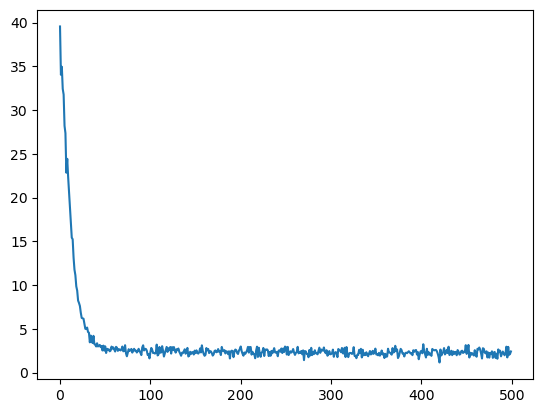

In [24]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
x=tf.linspace(-5,5,1000)
history = model.fit(x,epochs=500,verbose=0)
plt.plot(history.history["loss"])

In [ ]:
x_testv = tf.linspace(-2,2,1000)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv,np.exp(-x*x),label="exact")
plt.legend()
plt.show()